In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from transformers import AutoModelForImageClassification, AutoImageProcessor

from utils import load_image_hog

c:\Media\projects\ai-principles-and-methods\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
# pathes

image_dir="dataset/tom_and_jerry/tom_and_jerry"
os.listdir(image_dir)

['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']

In [4]:
all_images = {}
for root, dirs, files in os.walk(image_dir):
    for f in files:
        if f.endswith('.jpg'):
            all_images[f] = os.path.join(root, f)

In [5]:
csv_path = "dataset/ground_truth.csv"
df = pd.read_csv(csv_path)

df

,filename,tom,jerry
0,frame0.jpg,0,0
1,frame1.jpg,0,0
2,frame2.jpg,0,0
3,frame3.jpg,0,0
4,frame4.jpg,0,0
...,...,...,...
5473,frame5473.jpg,0,0
5474,frame5474.jpg,0,0
5475,frame5475.jpg,0,0
5476,frame5476.jpg,0,0


class distribution:
None: 1528 images (27.89%)
Jerry: 1240 images (22.64%)
Tom: 1930 images (35.23%)
Tom+Jerry: 780 images (14.24%)

total images: 5478


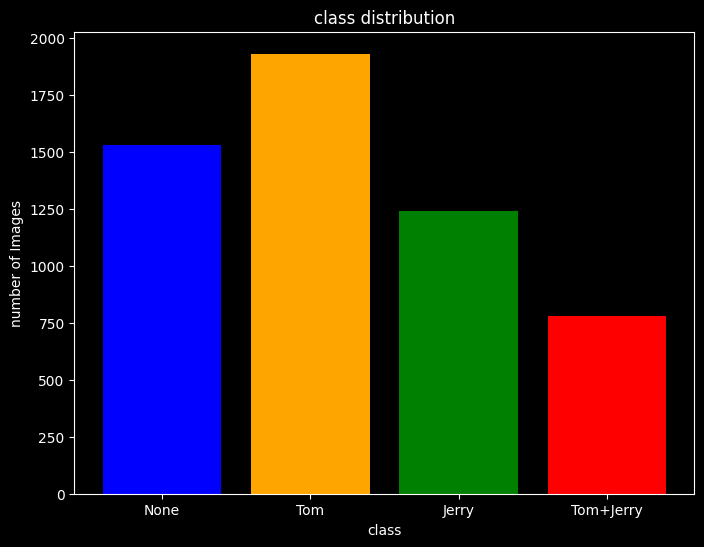

In [34]:
labels = []
for idx, row in df.iterrows():
    if row['tom'] == 0 and row['jerry'] == 0:
        labels.append(0)
    elif row['tom'] == 1 and row['jerry'] == 0:
        labels.append(1)
    elif row['tom'] == 0 and row['jerry'] == 1:
        labels.append(2)
    elif row['tom'] == 1 and row['jerry'] == 1:
        labels.append(3)

# class distribution
class_names = {0: "None", 1: "Tom", 2: "Jerry", 3: "Tom+Jerry"}
class_counts = Counter(labels)
print("class distribution:")
for class_id, count in class_counts.items():
    print(f"{class_names[class_id]}: {count} images ({count/len(labels)*100:.2f}%)")
print(f"\ntotal images: {sum(class_counts.values())}")

plt.figure(figsize=(8, 6))
plt.bar(class_names.values(), [class_counts[i] for i in range(4)], color=['blue', 'orange', 'green', 'red'])
plt.title("class distribution")
plt.xlabel("class")
plt.ylabel("number of Images")
plt.show()

### SVM

In [7]:
X, y = [], []

class_names = {0: "None", 1: "Tom", 2: "Jerry", 3: "Tom+Jerry"}

for idx, row in tqdm(df.iterrows(), total=len(df)):
    fname = row['filename']
    path = all_images.get(fname)
    if path is None:
        continue
    
    # extracting hog feats
    features = load_image_hog(path)
    X.append(features)
    
    # transform multi-label in single-label
    if row['tom'] == 0 and row['jerry'] == 0:
        y.append(0)
    elif row['tom'] == 1 and row['jerry'] == 0:
        y.append(1)
    elif row['tom'] == 0 and row['jerry'] == 1:
        y.append(2)
    elif row['tom'] == 1 and row['jerry'] == 1:
        y.append(3)
        
X = np.array(X)
y = np.array(y)

100%|██████████| 5478/5478 [00:14<00:00, 379.89it/s]


In [8]:
# standardize features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [10]:
print("is cuda available?:", torch.cuda.is_available())

is cuda available?: True


In [11]:
clf = xgb.XGBClassifier(n_estimators=100, tree_method='hist', device='cuda', )
clf.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [12]:
y_pred = clf.predict(X_test)

c:\Media\projects\ai-principles-and-methods\.venv\Lib\site-packages\xgboost\core.py:774: UserWarning: [20:41:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [13]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=list(class_names.values())))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

        None       0.78      0.76      0.77       305
         Tom       0.75      0.89      0.82       382
       Jerry       0.76      0.72      0.74       249
   Tom+Jerry       0.91      0.62      0.74       160

    accuracy                           0.78      1096
   macro avg       0.80      0.75      0.77      1096
weighted avg       0.78      0.78      0.78      1096

Accuracy: 0.7773722627737226


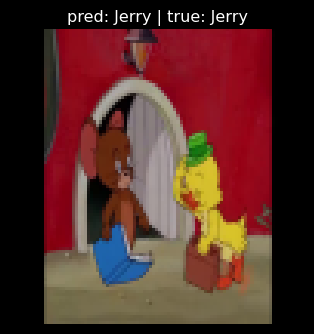

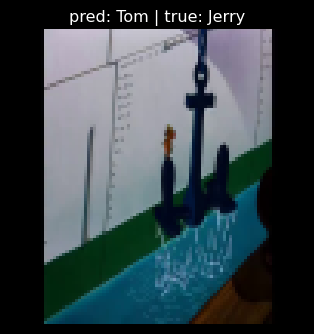

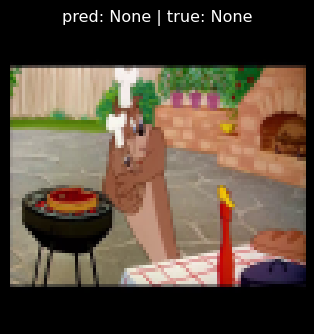

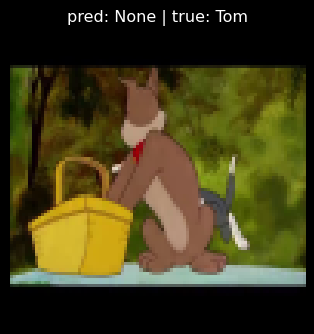

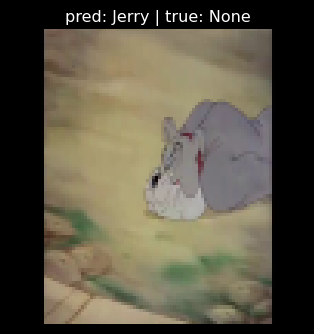

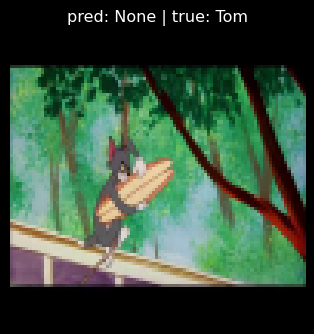

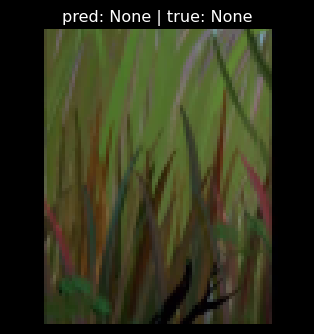

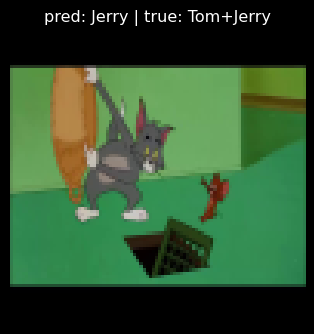

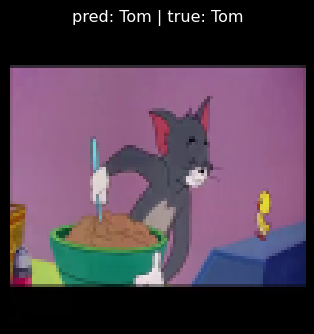

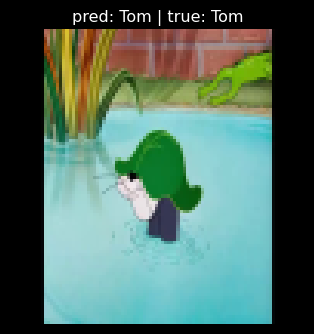

In [14]:
for i in range(10):
    idx = np.where((X_scaled == X_test[i]).all(axis=1))[0][0]
    fname = df.iloc[idx]['filename']
    img_path = all_images[fname]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_resized = cv2.resize(img, (96, 96), interpolation=cv2.INTER_AREA)
    
    pred_class = y_pred[i]
    true_class = y_test[i]
    
    plt.figure(figsize=(4, 4), dpi=96)
    plt.imshow(img_resized)
    plt.axis('off')
    plt.title(f"pred: {class_names[pred_class]} | true: {class_names[true_class]}")
    plt.show()


### splitting and processing dataset 

In [15]:
class TomAndJerryDataset(Dataset):
    def __init__(self, df, all_images, transform=None):
        self.df = df
        self.all_images = all_images
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row['filename']
        img_path = self.all_images.get(fname)
        if img_path is None:
            raise FileNotFoundError(f"Image {fname} not found")
        
        # Load and preprocess image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (96, 96))  # Resize to 96x96 as requested
        
        # Convert to tensor and apply transforms
        if self.transform:
            img = self.transform(img)
        
        # Create label
        if row['tom'] == 0 and row['jerry'] == 0:
            label = 0
        elif row['tom'] == 1 and row['jerry'] == 0:
            label = 1
        elif row['tom'] == 0 and row['jerry'] == 1:
            label = 2
        elif row['tom'] == 1 and row['jerry'] == 1:
            label = 3
        
        return img, label

In [16]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor (C, H, W) and normalize to [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [17]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [18]:
# Create datasets
train_dataset = TomAndJerryDataset(train_df, all_images, transform=transform)
test_dataset = TomAndJerryDataset(test_df, all_images, transform=transform)

In [19]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### CNN

In [ ]:
# Define CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # Extracting feats. 3x96x96 -> 32x96x96
            nn.ReLU(), # Activation fucntion
            nn.MaxPool2d(2, 2), # Decrease size in 2 times. 3x96x96 -> 32x48x48
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Learning more complex feats. 32x48x48 -> 64x48x48
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Decrease size in 2 times. 32x48x48 -> 64x24x24
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Learning more complex feats. 64x24x24 -> 128x24x24
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # Decrease size in 2 times. 128x24x24 ->  128x12x12
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 256),
            nn.ReLU(),
            nn.Dropout(0.5), # to prevent overfitting
            nn.Linear(256, 4)  # 4 classes: None, Tom, Jerry, Tom+Jerry
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

100%|██████████| 10/10 [01:45<00:00, 10.59s/it]


In [25]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_names.values())))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

        None       0.83      0.86      0.85       305
         Tom       0.90      0.90      0.90       382
       Jerry       0.87      0.87      0.87       249
   Tom+Jerry       0.87      0.81      0.84       160

    accuracy                           0.87      1096
   macro avg       0.87      0.86      0.86      1096
weighted avg       0.87      0.87      0.87      1096

Accuracy: 0.8695255474452555


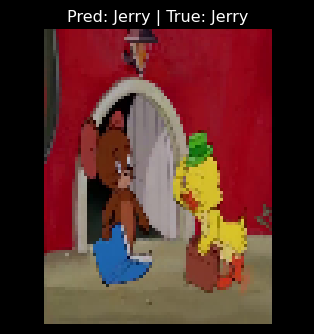

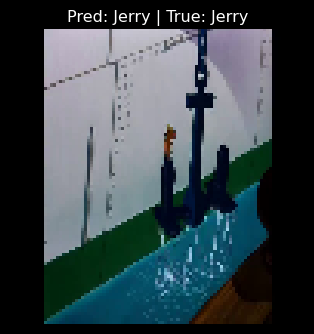

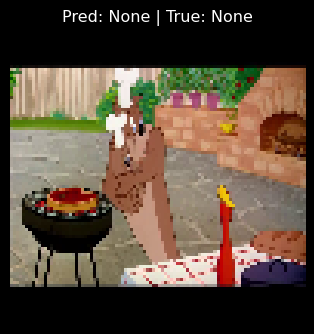

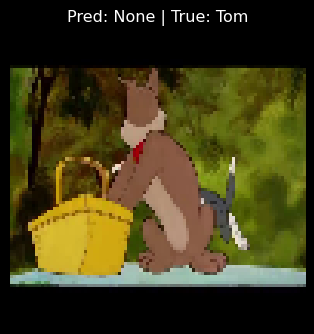

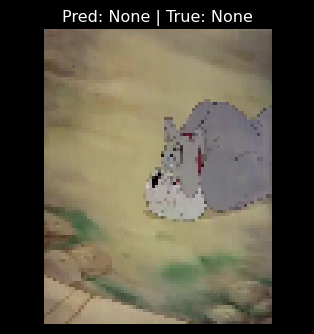

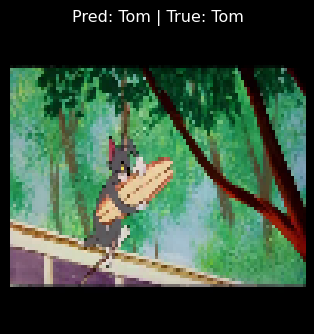

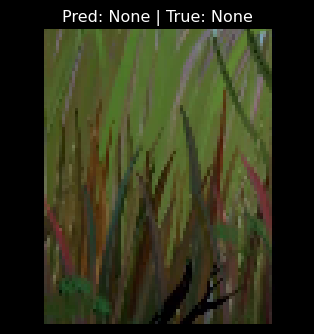

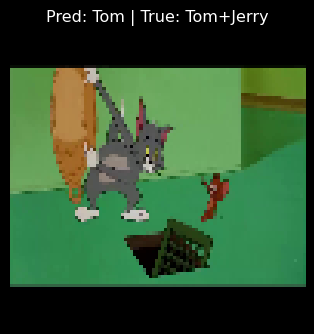

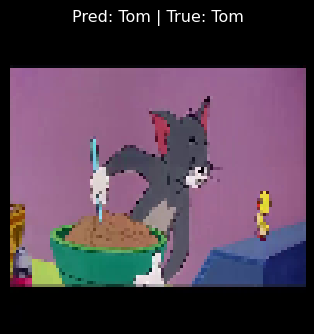

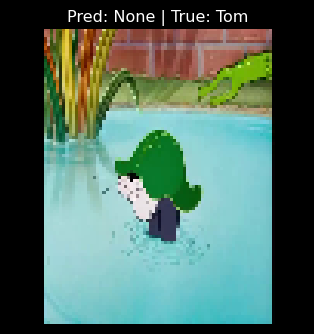

In [26]:
model.eval()
for i in range(10):
    img, true_label = test_dataset[i]
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred_label = torch.argmax(output, dim=1).item()
    
    img = img.squeeze(0).cpu().permute(1, 2, 0).numpy()
    img = (img * 0.5 + 0.5) * 255
    img = img.astype(np.uint8)
    
    plt.figure(figsize=(4, 4), dpi=96)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {class_names[pred_label]} | True: {class_names[true_label]}")
    plt.show()

### vision transformer (ViT) model trained using the google/vit-base-patch16-224

In [27]:
class TomAndJerryDataset(Dataset):
    def __init__(self, df, all_images, processor=None):
        self.df = df
        self.all_images = all_images
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row['filename']
        img_path = self.all_images.get(fname)
        if img_path is None:
            raise FileNotFoundError(f"Image {fname} not found")
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.processor:
            img = self.processor(img, return_tensors="pt")['pixel_values'].squeeze(0)  # (C, H, W)
        
        if row['tom'] == 0 and row['jerry'] == 0:
            label = 0
        elif row['tom'] == 1 and row['jerry'] == 0:
            label = 1
        elif row['tom'] == 0 and row['jerry'] == 1:
            label = 2
        elif row['tom'] == 1 and row['jerry'] == 1:
            label = 3
        
        return img, label

In [28]:
model_name = 'google/vit-base-patch16-224'
processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)

model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=4,  # 4 класса: None, Tom, Jerry, Tom+Jerry
    ignore_mismatched_sizes=True,
)

c:\Media\projects\ai-principles-and-methods\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\aywski\.cache\huggingface\hub\models--google--vit-base-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling b

In [29]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = TomAndJerryDataset(train_df, all_images, processor=processor)
test_dataset = TomAndJerryDataset(test_df, all_images, processor=processor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-5)

In [31]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(pixel_values=images, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Average Loss: 0.8683
Epoch 2, Average Loss: 0.2731
Epoch 3, Average Loss: 0.0888
Epoch 4, Average Loss: 0.0344
Epoch 5, Average Loss: 0.0179
Epoch 6, Average Loss: 0.0122
Epoch 7, Average Loss: 0.0071
Epoch 8, Average Loss: 0.0042
Epoch 9, Average Loss: 0.0029
Epoch 10, Average Loss: 0.0022


In [32]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images)
        _, predicted = torch.max(outputs.logits, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_names.values())))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

        None       0.95      0.96      0.95       305
         Tom       0.97      0.98      0.97       382
       Jerry       0.95      0.96      0.95       249
   Tom+Jerry       0.98      0.93      0.95       160

    accuracy                           0.96      1096
   macro avg       0.96      0.95      0.96      1096
weighted avg       0.96      0.96      0.96      1096

Accuracy: 0.9598540145985401


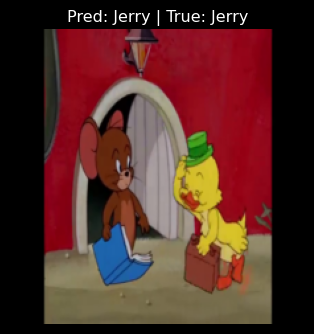

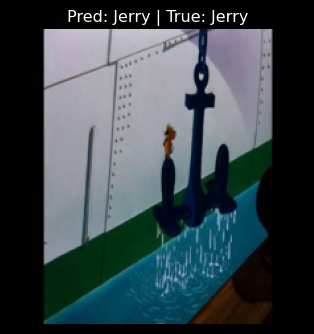

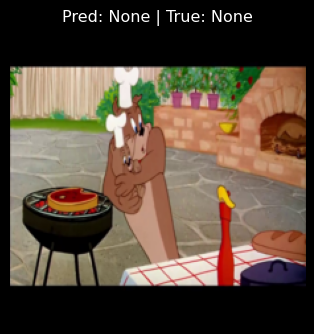

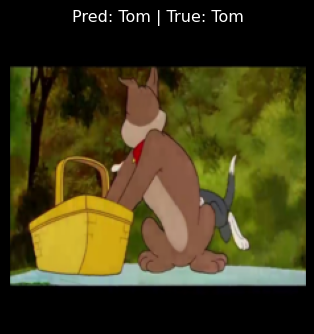

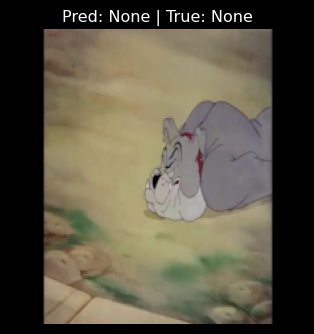

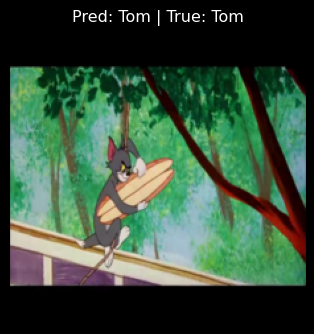

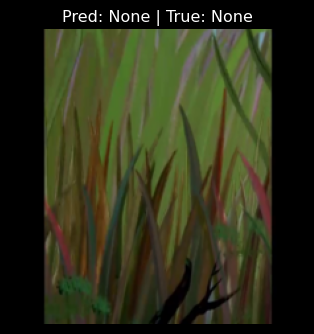

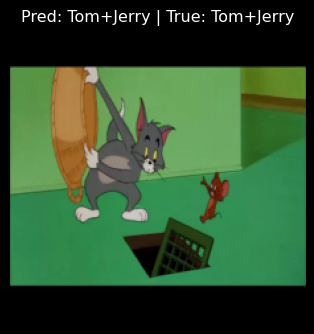

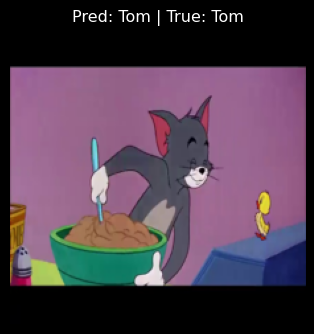

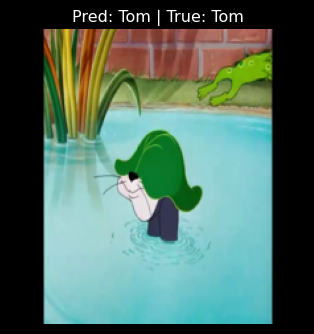

In [33]:
model.eval()
for i in range(10):
    img, true_label = test_dataset[i]
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(pixel_values=img)
        pred_label = torch.argmax(output.logits, dim=1).item()
    
    img = img.squeeze(0).cpu().permute(1, 2, 0).numpy()
    img = (img * 0.5 + 0.5) * 255 
    img = img.astype(np.uint8)
    
    plt.figure(figsize=(4, 4), dpi=96)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {class_names[pred_label]} | True: {class_names[true_label]}")
    plt.show()